In [ ]:
!unzip "/content/drive/MyDrive/ADL/casia-webface-20250517T050337Z-1-002.zip" -d "/content/drive/MyDrive/ADL"

Archive:  /content/drive/MyDrive/ADL/casia-webface-20250517T050337Z-1-002.zip
  inflating: /content/drive/MyDrive/ADL/casia-webface/property  
  inflating: /content/drive/MyDrive/ADL/casia-webface/train.idx  
  inflating: /content/drive/MyDrive/ADL/casia-webface/train.lst  


In [ ]:
! pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install facenet-pytorch torch torchvision numpy matplotlib

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

class TripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super().__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        pairwise_dist = torch.cdist(embeddings, embeddings, p=2)

        loss = 0.0
        triplet_count = 0

        for i in range(len(embeddings)):
            anchor_label = labels[i]
            anchor = embeddings[i]

            # Select positives and negatives
            mask_pos = (labels == anchor_label)
            mask_neg = (labels != anchor_label)

            pos_dist = pairwise_dist[i][mask_pos]
            neg_dist = pairwise_dist[i][mask_neg]

            # Skip if less than 1 positive or 1 negative
            if len(pos_dist) <= 1 or len(neg_dist) == 0:
                continue

            # Remove distance to itself from pos_dist
            pos_dist = pos_dist[pos_dist != 0]

            # Find semi-hard negatives: d(an) > d(ap) and d(an) < d(ap) + margin
            for d_ap in pos_dist:
                mask_semi_hard = (neg_dist > d_ap) & (neg_dist < d_ap + self.margin)
                semi_hard_negatives = neg_dist[mask_semi_hard]

                if len(semi_hard_negatives) > 0:
                    d_an = semi_hard_negatives.min()
                    loss += F.relu(d_ap - d_an + self.margin)
                    triplet_count += 1

        if triplet_count == 0:
            return torch.tensor(0.0, requires_grad=True, device=embeddings.device)
        return loss / triplet_count

# --- Accuracy Function ---
def batch_accuracy(embeddings, labels, threshold=0.5):
    norm_embeddings = F.normalize(embeddings, p=2, dim=1)
    similarity = torch.matmul(norm_embeddings, norm_embeddings.T)
    labels = labels.unsqueeze(1)
    same_mask = (labels == labels.T).float()
    diff_mask = 1 - same_mask
    diag_mask = torch.eye(same_mask.shape[0], device=same_mask.device)
    same_mask -= diag_mask
    same_correct = ((similarity >= threshold).float() * same_mask).sum()
    diff_correct = ((similarity < threshold).float() * diff_mask).sum()
    same_total = same_mask.sum()
    diff_total = diff_mask.sum()
    same_acc = same_correct / same_total if same_total > 0 else torch.tensor(0.0)
    diff_acc = diff_correct / diff_total if diff_total > 0 else torch.tensor(0.0)
    return same_acc.item(), diff_acc.item(), ((same_correct + diff_correct) / (same_total + diff_total)).item()

In [ ]:
# --- MobileNet Embedding Model ---
class MobileNetFaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.last_channel, embedding_dim)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = F.normalize(x, p=2, dim=1)  # L2 normalization here
        return x

# --- Setup ---
aligned_data_dir = '/content/drive/MyDrive/ADL/Image_Preprocessed'
model_save_path = '/content/drive/MyDrive/ADL/mobilenetv2_casia_trained.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(aligned_data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = MobileNetFaceEmbedder().to(device)
loss_fn = TripletLoss(margin=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
best_loss = float('inf')  # Track best loss

for epoch in range(10):
    model.train()
    total_loss = 0
    total_same_acc = 0
    total_diff_acc = 0
    total_batches = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        embeddings = model(imgs)
        loss = loss_fn(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        same_acc, diff_acc, _ = batch_accuracy(embeddings, labels)
        total_same_acc += same_acc
        total_diff_acc += diff_acc
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_same = total_same_acc * 100 / total_batches
    avg_diff = total_diff_acc * 100 / total_batches

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Same_acc={avg_same:.2f}% | Diff_acc={avg_diff:.2f}%")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_path = f"/content/drive/MyDrive/ADL/best_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} → {best_model_path}")

Epoch 1: Loss=0.2333 | Same_acc=46.18% | Diff_acc=80.17%
🟢 Best model saved at epoch 1 → /content/drive/MyDrive/ADL/best_model_epoch_1.pth
Epoch 2: Loss=0.2081 | Same_acc=57.14% | Diff_acc=77.96%
🟢 Best model saved at epoch 2 → /content/drive/MyDrive/ADL/best_model_epoch_2.pth
Epoch 3: Loss=0.2064 | Same_acc=58.80% | Diff_acc=78.69%
🟢 Best model saved at epoch 3 → /content/drive/MyDrive/ADL/best_model_epoch_3.pth
Epoch 4: Loss=0.2006 | Same_acc=63.37% | Diff_acc=78.52%
🟢 Best model saved at epoch 4 → /content/drive/MyDrive/ADL/best_model_epoch_4.pth
Epoch 5: Loss=0.1954 | Same_acc=63.24% | Diff_acc=79.61%
🟢 Best model saved at epoch 5 → /content/drive/MyDrive/ADL/best_model_epoch_5.pth
Epoch 6: Loss=0.1902 | Same_acc=62.27% | Diff_acc=80.70%
🟢 Best model saved at epoch 6 → /content/drive/MyDrive/ADL/best_model_epoch_6.pth


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# --- MobileNet Embedding Model ---
class MobileNetFaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.last_channel, embedding_dim)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = F.normalize(x, p=2, dim=1)  # L2 normalization here
        return x

# --- Setup ---
aligned_data_dir = '/content/drive/MyDrive/ADL/Image_Preprocessed'
model_save_path = '/content/drive/MyDrive/ADL/mobilenetv2_casia_trained.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(aligned_data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = MobileNetFaceEmbedder().to(device)
loss_fn = SemiHardTripletLoss(margin=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

checkpoint_path = '/content/drive/MyDrive/ADL/best_model_epoch_6.pth'  # or your actual file
model.load_state_dict(torch.load(checkpoint_path))
print("✅ Loaded model weights from:", checkpoint_path)

best_loss = float('inf')

# Continue training from epoch 7
for epoch in range(7, 10):
    model.train()
    total_loss = 0
    total_same_acc = 0
    total_diff_acc = 0
    total_batches = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        embeddings = model(imgs)
        loss = loss_fn(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        same_acc, diff_acc, _ = batch_accuracy(embeddings, labels)
        total_same_acc += same_acc
        total_diff_acc += diff_acc
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_same = total_same_acc * 100 / total_batches
    avg_diff = total_diff_acc * 100 / total_batches

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Same_acc={avg_same:.2f}% | Diff_acc={avg_diff:.2f}%")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_path = f"/content/drive/MyDrive/ADL/best_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"🟢 Best model saved at epoch {epoch+1} → {best_model_path}")

✅ Loaded model weights from: /content/drive/MyDrive/ADL/best_model_epoch_6.pth
Epoch 8: Loss=0.1944 | Same_acc=65.24% | Diff_acc=80.00%
🟢 Best model saved at epoch 8 → /content/drive/MyDrive/ADL/best_model_epoch_8.pth
Epoch 9: Loss=0.1938 | Same_acc=63.42% | Diff_acc=79.71%
🟢 Best model saved at epoch 9 → /content/drive/MyDrive/ADL/best_model_epoch_9.pth
Epoch 10: Loss=0.1923 | Same_acc=63.17% | Diff_acc=82.84%
🟢 Best model saved at epoch 10 → /content/drive/MyDrive/ADL/best_model_epoch_10.pth


In [1]:
!unzip "/content/drive/MyDrive/ADL/Unseen_data-20250518T073422Z-1-001.zip" -d "/content/drive/MyDrive/ADL"

Archive:  /content/drive/MyDrive/ADL/Unseen_data-20250518T073422Z-1-001.zip
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1462.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1453.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1456.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1463.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1461.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1460.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1459.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1450.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1458.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1451.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1454.jpg  
  inflating: /content/drive/MyDrive/ADL/Unseen_data/10/Copy of 1452.jpg  
  inflating: /content/drive/MyDrive/

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import random
from PIL import Image

# --- Paths ---
unseen_data_path = '/content/drive/MyDrive/ADL/Unseen_data'
model_path = '/content/drive/MyDrive/ADL/best_model_epoch_10.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Define MobileNetV2 Face Embedder ---
class MobileNetFaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.last_channel, embedding_dim)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = F.normalize(x, p=2, dim=1)
        return x

# --- Load model ---
model = MobileNetFaceEmbedder().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Loaded model from: {model_path}")

# --- Load unseen dataset ---
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(unseen_data_path, transform=transform)
print(f"Loaded {len(dataset)} unseen images from {len(dataset.classes)} classes.")

# --- Helper: Cosine Similarity ---
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# --- Evaluation parameters ---
num_pairs = 200
threshold = 0.55  # adjust if needed

same_total = 0
same_correct = 0
same_incorrect = 0
diff_total = 0
diff_incorrect = 0

# --- Group image indices by class ---
class_to_indices = {}
for idx, (_, label) in enumerate(dataset.samples):
    class_to_indices.setdefault(label, []).append(idx)

# --- SAME person pairs ---
for _ in range(num_pairs):
    label = random.choice([k for k in class_to_indices if len(class_to_indices[k]) >= 2])
    idx1, idx2 = random.sample(class_to_indices[label], 2)

    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        emb1 = model(img1).cpu().numpy()[0]
        emb2 = model(img2).cpu().numpy()[0]
    sim = cosine_sim(emb1, emb2)

    same_total += 1
    if sim >= threshold:
        same_correct += 1
    else:
        same_incorrect += 1  # false rejection

# --- DIFFERENT person pairs ---
for _ in range(num_pairs):
    label1, label2 = random.sample(list(class_to_indices.keys()), 2)
    idx1 = random.choice(class_to_indices[label1])
    idx2 = random.choice(class_to_indices[label2])

    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        emb1 = model(img1).cpu().numpy()[0]
        emb2 = model(img2).cpu().numpy()[0]
    sim = cosine_sim(emb1, emb2)

    diff_total += 1
    if sim >= threshold:
        diff_incorrect += 1  # false acceptance

# --- Final Metrics ---
msr = (same_correct / same_total) * 100
far = (diff_incorrect / diff_total) * 100
frr = (same_incorrect / same_total) * 100

print("\nEvaluation Results on Unseen Data:")
print(f"Match Success Rate (MSR): {msr:.2f}%")
print(f"False Acceptance Rate (FAR): {far:.2f}%")
print(f"False Rejection Rate (FRR): {frr:.2f}%")

Loaded model from: /content/drive/MyDrive/ADL/best_model_epoch_10.pth
Loaded 466 unseen images from 11 classes.

Evaluation Results on Unseen Data:
Match Success Rate (MSR): 90.00%
False Acceptance Rate (FAR): 52.50%
False Rejection Rate (FRR): 10.00%


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# --- MobileNet Embedding Model ---
class MobileNetFaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.last_channel, embedding_dim)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = F.normalize(x, p=2, dim=1)  # L2 normalization here
        return x

# --- Setup ---
aligned_data_dir = '/content/drive/MyDrive/ADL/Image_Preprocessed'
model_save_path = '/content/drive/MyDrive/ADL/mobilenetv2_casia_trained.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(aligned_data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = MobileNetFaceEmbedder().to(device)
loss_fn = SemiHardTripletLoss(margin=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

checkpoint_path = '/content/drive/MyDrive/ADL/best_model_epoch_10.pth'  # or your actual file
model.load_state_dict(torch.load(checkpoint_path))
print("Loaded model weights from:", checkpoint_path)

best_loss = float('inf')

# Continue training from epoch 7
for epoch in range(10, 15):
    model.train()
    total_loss = 0
    total_same_acc = 0
    total_diff_acc = 0
    total_batches = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        embeddings = model(imgs)
        loss = loss_fn(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        same_acc, diff_acc, _ = batch_accuracy(embeddings, labels)
        total_same_acc += same_acc
        total_diff_acc += diff_acc
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_same = total_same_acc * 100 / total_batches
    avg_diff = total_diff_acc * 100 / total_batches

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Same_acc={avg_same:.2f}% | Diff_acc={avg_diff:.2f}%")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_path = f"/content/drive/MyDrive/ADL/best_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} → {best_model_path}")

Loaded model weights from: /content/drive/MyDrive/ADL/best_model_epoch_10.pth
Epoch 11: Loss=0.1905 | Same_acc=67.81% | Diff_acc=81.84%
Best model saved at epoch 11 → /content/drive/MyDrive/ADL/best_model_epoch_11.pth
Epoch 12: Loss=0.1887 | Same_acc=65.59% | Diff_acc=83.06%
Best model saved at epoch 12 → /content/drive/MyDrive/ADL/best_model_epoch_12.pth
Epoch 13: Loss=0.1851 | Same_acc=64.91% | Diff_acc=84.09%
Best model saved at epoch 13 → /content/drive/MyDrive/ADL/best_model_epoch_13.pth
Epoch 14: Loss=0.1882 | Same_acc=66.31% | Diff_acc=84.84%
Epoch 15: Loss=0.1832 | Same_acc=64.88% | Diff_acc=86.04%
Best model saved at epoch 15 → /content/drive/MyDrive/ADL/best_model_epoch_15.pth


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import random
from PIL import Image

# --- Paths ---
unseen_data_path = '/content/drive/MyDrive/ADL/Unseen_data'
model_path = '/content/drive/MyDrive/ADL/best_model_epoch_15.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Define MobileNetV2 Face Embedder ---
class MobileNetFaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.last_channel, embedding_dim)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = F.normalize(x, p=2, dim=1)
        return x

# --- Load model ---
model = MobileNetFaceEmbedder().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Loaded model from: {model_path}")

# --- Load unseen dataset ---
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(unseen_data_path, transform=transform)
print(f"Loaded {len(dataset)} unseen images from {len(dataset.classes)} classes.")

# --- Helper: Cosine Similarity ---
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# --- Evaluation parameters ---
num_pairs = 200
threshold = 0.55  # adjust if needed

same_total = 0
same_correct = 0
same_incorrect = 0
diff_total = 0
diff_incorrect = 0

# --- Group image indices by class ---
class_to_indices = {}
for idx, (_, label) in enumerate(dataset.samples):
    class_to_indices.setdefault(label, []).append(idx)

# --- SAME person pairs ---
for _ in range(num_pairs):
    label = random.choice([k for k in class_to_indices if len(class_to_indices[k]) >= 2])
    idx1, idx2 = random.sample(class_to_indices[label], 2)

    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        emb1 = model(img1).cpu().numpy()[0]
        emb2 = model(img2).cpu().numpy()[0]
    sim = cosine_sim(emb1, emb2)

    same_total += 1
    if sim >= threshold:
        same_correct += 1
    else:
        same_incorrect += 1  # false rejection

# --- DIFFERENT person pairs ---
for _ in range(num_pairs):
    label1, label2 = random.sample(list(class_to_indices.keys()), 2)
    idx1 = random.choice(class_to_indices[label1])
    idx2 = random.choice(class_to_indices[label2])

    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        emb1 = model(img1).cpu().numpy()[0]
        emb2 = model(img2).cpu().numpy()[0]
    sim = cosine_sim(emb1, emb2)

    diff_total += 1
    if sim >= threshold:
        diff_incorrect += 1  # false acceptance

# --- Final Metrics ---
msr = (same_correct / same_total) * 100
far = (diff_incorrect / diff_total) * 100
frr = (same_incorrect / same_total) * 100

print("\nEvaluation Results on Unseen Data:")
print(f"Match Success Rate (MSR): {msr:.2f}%")
print(f"False Acceptance Rate (FAR): {far:.2f}%")
print(f"False Rejection Rate (FRR): {frr:.2f}%")

Loaded model from: /content/drive/MyDrive/ADL/best_model_epoch_15.pth
Loaded 466 unseen images from 11 classes.

Evaluation Results on Unseen Data:
Match Success Rate (MSR): 73.50%
False Acceptance Rate (FAR): 32.50%
False Rejection Rate (FRR): 26.50%


In [9]:
thresholds = [0.45, 0.50, 0.55, 0.60, 0.65, 0.70]

for threshold in thresholds:
    same_total = 0
    same_correct = 0
    same_incorrect = 0
    diff_total = 0
    diff_incorrect = 0

    # --- SAME person pairs ---
    for _ in range(200):
        label = random.choice([k for k in class_to_indices if len(class_to_indices[k]) >= 2])
        idx1, idx2 = random.sample(class_to_indices[label], 2)

        img1, _ = dataset[idx1]
        img2, _ = dataset[idx2]
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)

        emb1 = model(img1).detach().cpu().numpy()[0]
        emb2 = model(img2).detach().cpu().numpy()[0]
        sim = cosine_sim(emb1, emb2)

        same_total += 1
        if sim >= threshold:
            same_correct += 1
        else:
            same_incorrect += 1  # false reject

    # --- DIFFERENT person pairs ---
    for _ in range(200):
        label1, label2 = random.sample(list(class_to_indices.keys()), 2)
        idx1 = random.choice(class_to_indices[label1])
        idx2 = random.choice(class_to_indices[label2])

        img1, _ = dataset[idx1]
        img2, _ = dataset[idx2]
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)

        emb1 = model(img1).detach().cpu().numpy()[0]
        emb2 = model(img2).detach().cpu().numpy()[0]
        sim = cosine_sim(emb1, emb2)

        diff_total += 1
        if sim >= threshold:
            diff_incorrect += 1  # false accept

    # --- Metrics ---
    msr = (same_correct / same_total) * 100
    far = (diff_incorrect / diff_total) * 100
    frr = (same_incorrect / same_total) * 100

    print(f"\nThreshold = {threshold}")
    print(f"Match Success Rate (MSR): {msr:.2f}%")
    print(f"False Acceptance Rate (FAR): {far:.2f}%")
    print(f"False Rejection Rate (FRR): {frr:.2f}%")


Threshold = 0.45
Match Success Rate (MSR): 76.50%
False Acceptance Rate (FAR): 37.00%
False Rejection Rate (FRR): 23.50%

Threshold = 0.5
Match Success Rate (MSR): 78.00%
False Acceptance Rate (FAR): 40.00%
False Rejection Rate (FRR): 22.00%

Threshold = 0.55
Match Success Rate (MSR): 73.00%
False Acceptance Rate (FAR): 31.50%
False Rejection Rate (FRR): 27.00%

Threshold = 0.6
Match Success Rate (MSR): 62.00%
False Acceptance Rate (FAR): 31.00%
False Rejection Rate (FRR): 38.00%

Threshold = 0.65
Match Success Rate (MSR): 68.50%
False Acceptance Rate (FAR): 25.00%
False Rejection Rate (FRR): 31.50%

Threshold = 0.7
Match Success Rate (MSR): 54.00%
False Acceptance Rate (FAR): 25.50%
False Rejection Rate (FRR): 46.00%


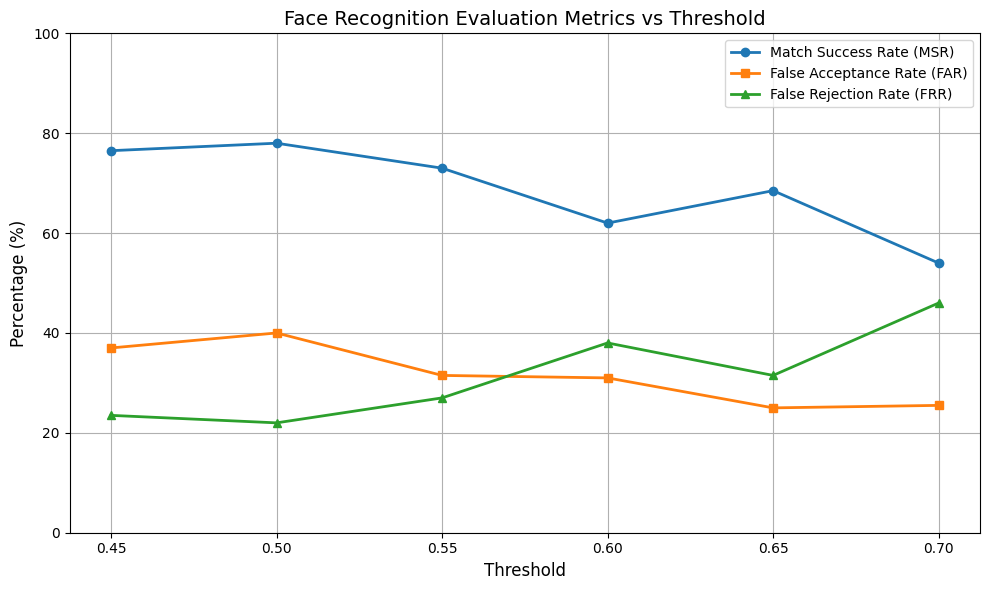

In [10]:
import matplotlib.pyplot as plt

# --- Threshold values you tested ---
thresholds = [0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

# --- Your recorded metrics from each threshold ---
msr = [76.50, 78.00, 73.00, 62.00, 68.50, 54.00]
far = [37.00, 40.00, 31.50, 31.00, 25.00, 25.50]
frr = [23.50, 22.00, 27.00, 38.00, 31.50, 46.00]

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, msr, marker='o', label='Match Success Rate (MSR)', linewidth=2)
plt.plot(thresholds, far, marker='s', label='False Acceptance Rate (FAR)', linewidth=2)
plt.plot(thresholds, frr, marker='^', label='False Rejection Rate (FRR)', linewidth=2)

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("Face Recognition Evaluation Metrics vs Threshold", fontsize=14)
plt.grid(True)
plt.legend()
plt.xticks(thresholds)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Loaded model from: /content/drive/MyDrive/ADL/best_model_epoch_15.pth


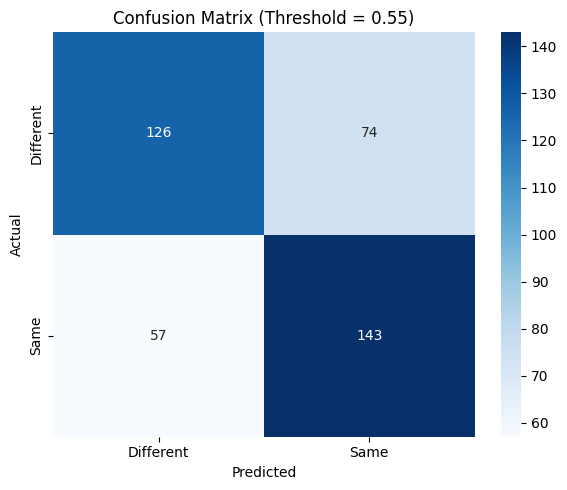

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Paths ---
unseen_data_path = '/content/drive/MyDrive/ADL/Unseen_data'
model_path = '/content/drive/MyDrive/ADL/best_model_epoch_15.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Load model ---
model = MobileNetFaceEmbedder().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Loaded model from: {model_path}")

# --- Load dataset ---
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(unseen_data_path, transform=transform)

# --- Cosine similarity function ---
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# --- Evaluation ---
num_pairs = 200
threshold = 0.55

y_true = []  # actual
y_pred = []  # predicted

# Group by class
class_to_indices = {}
for idx, (_, label) in enumerate(dataset.samples):
    class_to_indices.setdefault(label, []).append(idx)

# SAME person pairs
for _ in range(num_pairs):
    label = random.choice([k for k in class_to_indices if len(class_to_indices[k]) >= 2])
    idx1, idx2 = random.sample(class_to_indices[label], 2)

    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    emb1 = model(img1).detach().cpu().numpy()[0]
    emb2 = model(img2).detach().cpu().numpy()[0]
    sim = cosine_sim(emb1, emb2)

    y_true.append(1)  # same
    y_pred.append(1 if sim >= threshold else 0)

# DIFFERENT person pairs
for _ in range(num_pairs):
    label1, label2 = random.sample(list(class_to_indices.keys()), 2)
    idx1 = random.choice(class_to_indices[label1])
    idx2 = random.choice(class_to_indices[label2])

    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    emb1 = model(img1).detach().cpu().numpy()[0]
    emb2 = model(img2).detach().cpu().numpy()[0]
    sim = cosine_sim(emb1, emb2)

    y_true.append(0)  # different
    y_pred.append(1 if sim >= threshold else 0)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
labels = ['Different', 'Same']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.tight_layout()
plt.show()